In [1]:
#import os
#os.environ ['KAGGLE_CONFIG_DIR']= '/content'

In [2]:
#!kaggle datasets download -d ruizgara/socofing

In [3]:
#!unzip \*.zip && rm *.zip

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt

In [5]:
def extract_label(img_path,train = True):
  filename, _ = os.path.splitext(os.path.basename(img_path))

  subject_id, etc = filename.split('__')

  if train:
      gender, lr, finger, _, _ = etc.split('_')
  else:
      gender, lr, finger, _ = etc.split('_')

  gender = 0 if gender == 'M' else 1
  lr = 0 if lr == 'Left' else 1

  if finger == 'thumb':
      finger = 0
  elif finger == 'index':
      finger = 1
  elif finger == 'middle':
      finger = 2
  elif finger == 'ring':
      finger = 3
  elif finger == 'little':
      finger = 4
  return np.array([gender], dtype=np.uint16)
img_size = 96


In [6]:
def loading_data(path,train):
    print("loading data from: ",path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (img_size, img_size))
            label = extract_label(os.path.join(path, img),train)
            data.append([label[0], img_resize ])
        except Exception as e:
            pass
    data
    return data

In [7]:
Real_path = "/content/socofing/SOCOFing/Real"
Easy_path = "/content/socofing/SOCOFing/Altered/Altered-Easy"
Medium_path = "/content/socofing/SOCOFing/Altered/Altered-Medium"
Hard_path = "/content/socofing/SOCOFing/Altered/Altered-Hard"

Easy_data = loading_data(Easy_path, train = True)
Medium_data = loading_data(Medium_path, train = True)
Hard_data = loading_data(Hard_path, train = True)
test = loading_data(Real_path, train = False)

data = np.concatenate([Easy_data, Medium_data, Hard_data], axis=0)

del Easy_data, Medium_data, Hard_data

loading data from:  /content/socofing/SOCOFing/Altered/Altered-Easy
loading data from:  /content/socofing/SOCOFing/Altered/Altered-Medium
loading data from:  /content/socofing/SOCOFing/Altered/Altered-Hard
loading data from:  /content/socofing/SOCOFing/Real


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [8]:
import random
random.shuffle(data)
random.shuffle(test)
data


array([[0, array([[160, 158, 158, ...,   0,   0,   0],
                  [160, 105, 121, ...,   0,   0,   0],
                  [160, 105, 255, ...,   0,   0,   0],
                  ...,
                  [  0,   0,   0, ...,   0,   0,   0],
                  [  0,   0,   0, ...,   0,   0,   0],
                  [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)],
       [0, array([[160, 158, 158, ...,   0,   0,   0],
                  [160, 105, 121, ...,   0,   0,   0],
                  [160, 105, 255, ...,   0,   0,   0],
                  ...,
                  [  0,   0,   0, ...,   0,   0,   0],
                  [  0,   0,   0, ...,   0,   0,   0],
                  [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)],
       [0, array([[160, 158, 158, ...,   0,   0,   0],
                  [160, 105, 121, ...,   0,   0,   0],
                  [160, 105, 255, ...,   0,   0,   0],
                  ...,
                  [  0,   0,   0, ...,   0,   0,   0],
                  [

In [9]:
from tensorflow.keras.utils import to_categorical

In [10]:
img, labels = [], []
for label, feature in data:
    labels.append(label)
    img.append(feature)
train_data = np.array(img).reshape(-1, img_size, img_size, 1)
train_data = train_data / 255.0
#from keras.utils.np_utils import to_categorical
train_labels = to_categorical(labels, num_classes = 2)

In [11]:
del data
train_data

train_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [12]:
train_data.shape  , train_labels.shape

((49270, 96, 96, 1), (49270, 2))

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = Sequential([
                    Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_uniform', input_shape = [96, 96, 1]),
                    MaxPooling2D(2),
                    Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
                    MaxPooling2D(2),
                    Flatten(),
                    Dense(128, kernel_initializer='he_uniform',activation = 'relu'),
                    Dense(2, activation = 'softmax'),
                    ])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2

In [14]:

model.compile(optimizer = optimizers.Adam(1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


history = model.fit(train_data, train_labels, batch_size = 128, epochs = 30,
          validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 1)



Epoch 1/30
308/308 [==============================] - 16s 33ms/step - loss: 0.5849 - accuracy: 0.7940 - val_loss: 0.4048 - val_accuracy: 0.8221
Epoch 2/30
308/308 [==============================] - 7s 23ms/step - loss: 0.3229 - accuracy: 0.8629 - val_loss: 0.3149 - val_accuracy: 0.8709
Epoch 3/30
308/308 [==============================] - 7s 22ms/step - loss: 0.2030 - accuracy: 0.9229 - val_loss: 0.2077 - val_accuracy: 0.9165
Epoch 4/30
308/308 [==============================] - 7s 23ms/step - loss: 0.1284 - accuracy: 0.9527 - val_loss: 0.1875 - val_accuracy: 0.9269
Epoch 5/30
308/308 [==============================] - 7s 22ms/step - loss: 0.0816 - accuracy: 0.9711 - val_loss: 0.1423 - val_accuracy: 0.9481
Epoch 6/30
308/308 [==============================] - 7s 23ms/step - loss: 0.0448 - accuracy: 0.9862 - val_loss: 0.1359 - val_accuracy: 0.9538
Epoch 7/30
308/308 [==============================] - 7s 22ms/step - loss: 0.0317 - accuracy: 0.9910 - val_loss: 0.1156 - val_accuracy: 0.960

188/188 [==============================] - 1s 4ms/step - loss: 0.0319 - accuracy: 0.9933


[0.031905658543109894, 0.9933333396911621]

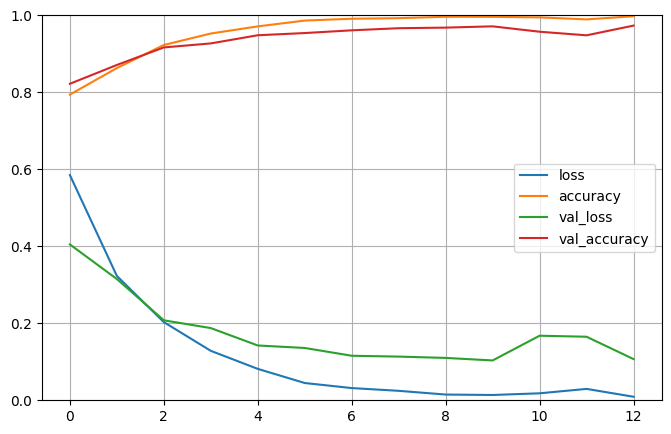

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)


test



test_images, test_labels = [], []

for label, feature in test:
    test_images.append(feature)
    test_labels.append(label)

test_images = np.array(test_images).reshape(-1, img_size, img_size, 1)
test_images = test_images / 255.0
del test
test_labels  = to_categorical(test_labels, num_classes = 2)
test_images



model.evaluate(test_images, test_labels)